In this notebook, I create features for future use in modelling attempts.

In [219]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import mca

from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

In [186]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [187]:
listings19 = pd.read_csv('data19/listings2019_cleaned.csv')
for col in listings19.columns:
    print(col)

id
listing_url
scrape_id
last_scraped
summary
space
description
neighborhood_overview
notes
transit
house_rules
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
smart_location
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness

In [188]:
X_binary = listings19[['oven','gym','tv','cable','free_parking','breakfast','real_bed',
                        'pets','children','aircon','wifi','washer','garden','dishwasher',
                        'crib','workspace','lift','wheelchair_access','balcony','bathtub',
                        'lugagge_dropoff','self_checkin','dryer','waterfront','fireplace',
                        'Area_Bruntsfield','Area_Cannonmills','Area_Haymarket','host_in_edin',
                        'Area_Leith','Area_Marchmont','Area_Morningside','Area_New Town','Area_Newington',
                        'Area_Old Town','Area_Southside','Area_Stockbridge','Area_Tollcross','Area_West End',
                        'house','apartment','hotel','hostel','host_identity_verified',
                         'host_has_profile_pic','host_is_superhost','other_property_type']]

## Feature Selection

### Principal Components Analysis 

#### Reviews

Notes to self:
-Very simple structure for picking the number of principal components to use (also use skree plot)
-70 - 80% of the information
-Correlation of factors with original variables

I investigate the principal components of the reviews in an attempt to capture the main variance in review scores.

In [189]:
reviews = listings19[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                          'review_scores_checkin','review_scores_communication','review_scores_location',
                          'review_scores_value']]

reviews.head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,99.0,10.0,10.0,10.0,10.0,10.0,10.0
1,92.0,10.0,9.0,10.0,10.0,10.0,9.0
2,93.0,10.0,10.0,10.0,10.0,9.0,10.0
3,98.0,10.0,10.0,10.0,10.0,10.0,10.0
4,97.0,10.0,10.0,10.0,10.0,10.0,10.0


In [190]:
scaler = StandardScaler()
scaled_reviews = scaler.fit_transform(reviews)

In [191]:
pca = decomposition.PCA()
review_pca = pca.fit_transform(scaled_reviews)

pca.explained_variance_ratio_

array([0.58429604, 0.11425823, 0.10484462, 0.05717805, 0.05424936,
       0.05089143, 0.03428227])

The first principal component appears to represent Airbnb's with unusually poor reviews in every category. This is interesting, because in the eda stage I observed that most Airbnbs actually received very good ratings in most categories. However, the review principal components still don't correlate very strongly with price. 

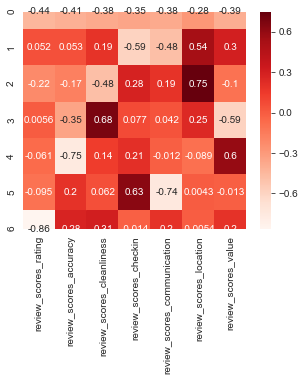

In [192]:
comps = pd.DataFrame(pca.components_, columns=reviews.columns)
comps

sb.heatmap(comps, cmap="Reds", annot=True)

In [193]:
review_pcs = pd.DataFrame(data = review_pca, columns = ['review_pc%s' % num for num in range(7)])
listings19 = pd.concat([review_pcs, listings19], axis = 1)

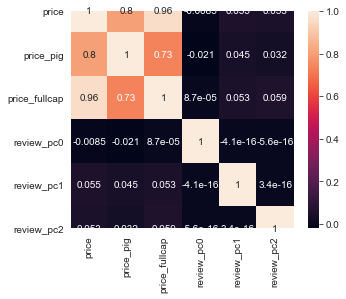

,price,price_pig,price_fullcap,review_pc0,review_pc1,review_pc2
price,1.000000,0.802754,0.962600,-8.525416e-03,5.456811e-02,5.259676e-02
price_pig,0.802754,1.000000,0.734384,-2.141900e-02,4.466084e-02,3.181568e-02
price_fullcap,0.962600,0.734384,1.000000,8.743932e-05,5.280277e-02,5.934161e-02
review_pc0,-0.008525,-0.021419,0.000087,1.000000e+00,-4.096170e-16,-5.575965e-16
review_pc1,0.054568,0.044661,0.052803,-4.096170e-16,1.000000e+00,3.428265e-16
review_pc2,0.052597,0.031816,0.059342,-5.575965e-16,3.428265e-16,1.000000e+00


In [194]:
corrMatrix = listings19[['price', 'price_pig', 'price_fullcap', 'review_pc0', 'review_pc1', 'review_pc2']].corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

### Multiple Correspondence Analysis

#### Amenities

There are 25 amenities in the dataset which are encoded 1 for present and 0 for absent. I use multiple correspondence analysis (MCA) to reduce the dimensionality of these binary variables. The `mca` package gives 13 components describing these 25 features. The strongest correlations with price observed for the raw variables was 0.01. The components here do not fare much better - the strongest correlations are around 0.11.

In [195]:
amenities = listings19[['oven','gym','tv','cable','free_parking','breakfast','real_bed',
                        'pets','children','aircon','wifi','washer','garden','dishwasher',
                        'crib','workspace','lift','wheelchair_access','balcony','bathtub',
                        'lugagge_dropoff','self_checkin','dryer','waterfront','fireplace']]

mca_df = mca.MCA(amenities)

In [196]:
# the eigenvalues: the proportion of variance accounted for by each factor 
mca_df.L

array([0.02197494, 0.01467273, 0.00951013, 0.00827244, 0.00738156,
       0.0052432 , 0.00458553, 0.00403974, 0.00361228, 0.0032955 ,
       0.00278323, 0.00248064, 0.0022101 , 0.00179679, 0.00154741,
       0.00141766, 0.00116141, 0.00092939, 0.00087299])

In [197]:
# corrections and thresholding leave us with 13 components
mca_fsr = mca_df.fs_r()
mca_fsr.shape

(10767, 13)

In [198]:
amenities_mcs = pd.DataFrame(data = mca_fsr, columns = ['amenities_mc%s' % num for num in range(13)])
listings19 = pd.concat([amenities_mcs, listings19], axis = 1)

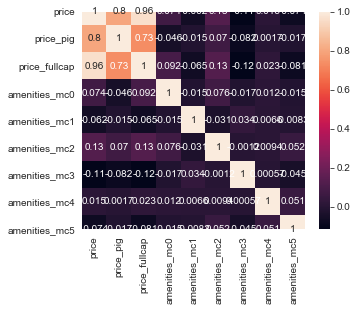

,price,price_pig,price_fullcap,amenities_mc0,amenities_mc1,amenities_mc2,amenities_mc3,amenities_mc4,amenities_mc5
price,1.000000,0.802754,0.962600,0.073569,-0.062132,0.125290,-0.112158,0.014898,-0.073988
price_pig,0.802754,1.000000,0.734384,-0.046254,-0.014923,0.069820,-0.081954,0.001713,-0.016804
price_fullcap,0.962600,0.734384,1.000000,0.091781,-0.064684,0.126373,-0.115670,0.022650,-0.080767
amenities_mc0,0.073569,-0.046254,0.091781,1.000000,-0.014638,0.075660,-0.017167,0.012440,-0.014567
amenities_mc1,-0.062132,-0.014923,-0.064684,-0.014638,1.000000,-0.031363,0.034042,0.006636,-0.008290
amenities_mc2,0.125290,0.069820,0.126373,0.075660,-0.031363,1.000000,-0.001219,0.009433,0.052286
amenities_mc3,-0.112158,-0.081954,-0.115670,-0.017167,0.034042,-0.001219,1.000000,0.000571,-0.045050
amenities_mc4,0.014898,0.001713,0.022650,0.012440,0.006636,0.009433,0.000571,1.000000,0.051489
amenities_mc5,-0.073988,-0.016804,-0.080767,-0.014567,-0.008290,0.052286,-0.045050,0.051489,1.000000


In [199]:
corrMatrix = listings19[['price', 'price_pig', 'price_fullcap', 'amenities_mc0', 'amenities_mc1',
                         'amenities_mc2','amenities_mc3','amenities_mc4','amenities_mc5']].corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## LASSO for Feature Selection

I begin with a naive model that uses all of the suspected predictors. In LASSO, two of these predictors have their coefficients set to 0: `host_is_superhost` and `host_identity_verified`. I drop these two variables from the predictors.

In [200]:
listings19 = listings19.drop(['listing_url', 'scrape_id', 'last_scraped', 'summary', 'space', 'description', 'neighborhood_overview',
                'notes', 'transit', 'house_rules', 'picture_url', 'host_url', 'host_name', 'host_about', 'street', 'country',
                'calendar_last_scraped'], axis = 1)

In [201]:
X_naive = listings19[['host_response_time', 'host_response_rate','host_listings_count',
                          'latitude','longitude','bath_bed_ratio','host_in_edin','host_is_superhost','host_identity_verified',
                          'house','apartment','hotel','hostel','amenities_mc1',
                          'amenities_mc2','amenities_mc3','amenities_mc4','amenities_mc5',
                          'other_property_type','Area_Bruntsfield','Area_Cannonmills','Area_Haymarket',
                          'Area_Leith','Area_Marchmont','Area_Morningside','Area_New Town','Area_Newington',
                          'Area_Old Town','Area_Southside','Area_Stockbridge','Area_Tollcross','Area_West End',
                          'review_pc0', 'review_pc1', 'review_pc2']]

y = listings19['price']

X_train, X_test, y_train, y_test = train_test_split(X_naive, y, test_size=0.2, random_state=101)

In [202]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(scaler.fit_transform(X_train), y_train)

C:\Users\s1533194\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s1533194\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [203]:
selected_feat = X_train.columns[(sel_.get_support())]
rejected_feat = X_train.columns[np.invert(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

rejected_feat

total features: 35
selected features: 33


Index(['host_is_superhost', 'host_identity_verified'], dtype='object')

## Initial Modelling

First I attempt a very simple linear regression. This has a coefficient of determination of 0.15.

In [213]:
X_train = X_train.loc[:, (sel_.get_support())]
X_test = X_test.loc[:, (sel_.get_support())]

In [220]:
regr = LinearRegression()
initial_fit = regr.fit(X_train, y_train)

y_pred = initial_fit.predict(X_test)

print('Coefficients: \n', initial_fit.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [-3.67176745e-01 -3.52848641e-01  7.04786776e-02 -2.08951816e+02
 -4.46976178e+02 -5.90916912e+01 -8.43084592e+00 -1.20489141e+01
 -3.41658746e+01 -1.01069600e+01  1.02766198e+02 -6.98537185e+01
  6.82515960e+01 -5.83670386e+01  2.37128170e+01 -7.11056794e+01
 -4.64444491e+01 -9.07947306e+00  7.91810109e+00 -3.12540754e+01
 -1.08388726e+00  1.02143029e+01 -3.22266451e+01  2.99542177e+01
  4.90477644e+00  2.06421862e+01  1.10660426e+01 -4.31048384e+00
 -1.29655675e+01  6.22050530e+00 -1.62976935e+00  1.28831582e+00
  7.19108836e-01]
Mean squared error: 6178.40
Coefficient of determination: 0.15
